In [1]:
!python -V

Python 3.12.3


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [6]:
import mlflow


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2026/01/12 16:53:03 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/12 16:53:03 INFO mlflow.store.db.utils: Updating database tables
2026/01/12 16:53:03 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/12 16:53:03 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/12 16:53:03 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/12 16:53:03 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops-course/02-experiment-tracking/mlruns/1', creation_time=1768224496122, experiment_id='1', last_update_time=1768224496122, lifecycle_stage='active', name='nyc-taxi-experiment', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.0603515377817025

C:\Users\barto\AppData\Local\Temp\ipykernel_24368\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\barto\AppData\Local\Temp\ipykernel_24368\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


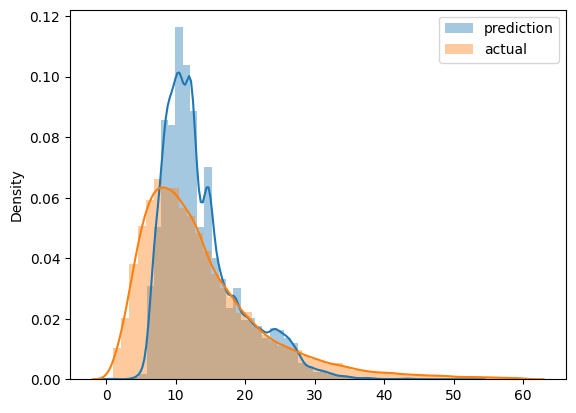

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.75871520940454

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

11.167275942353895

In [ ]:
with mlflow.start_run():

    mlflow.set_tag('developer', 'bg')

    mlflow.log_param('train-data-path', "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param('valid-data-path', "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

    alpha = 0.1
    mlflow.log_param('alpha', alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric('rmse', rmse)

    mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')

In [20]:
import xgboost as xgb

In [21]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [22]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=500,
            evals=[(valid, 'validation')],
            early_stopping_rounds=25
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric('rmse', rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [24]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:53:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:11.50961                          
[1]	validation-rmse:10.88540                          
[2]	validation-rmse:10.33308                          
[3]	validation-rmse:9.84597                           
[4]	validation-rmse:9.41819                           
[5]	validation-rmse:9.04248                           
[6]	validation-rmse:8.71409                           
[7]	validation-rmse:8.42782                           
[8]	validation-rmse:8.17876                           
[9]	validation-rmse:7.96258                           
[10]	validation-rmse:7.77525                          
[11]	validation-rmse:7.61319                          
[12]	validation-rmse:7.47427                          
[13]	validation-rmse:7.35258                          
[14]	validation-rmse:7.24812                          
[15]	validation-rmse:7.15788                          
[16]	validation-rmse:7.07961                          
[17]	validation-rmse:7.01193                          
[18]	valid

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:54:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:7.56791                                                    
[1]	validation-rmse:6.69549                                                    
[2]	validation-rmse:6.53527                                                    
[3]	validation-rmse:6.48428                                                    
[4]	validation-rmse:6.46067                                                    
[5]	validation-rmse:6.45200                                                    
[6]	validation-rmse:6.44707                                                    
[7]	validation-rmse:6.44089                                                    
[8]	validation-rmse:6.43762                                                    
[9]	validation-rmse:6.43416                                                    
[10]	validation-rmse:6.42788                                                   
[11]	validation-rmse:6.42291                                                   
[12]	validation-rmse:6.41954            

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:54:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.84098                                                   
[1]	validation-rmse:9.78665                                                    
[2]	validation-rmse:8.97959                                                    
[3]	validation-rmse:8.37044                                                    
[4]	validation-rmse:7.90703                                                    
[5]	validation-rmse:7.56793                                                    
[6]	validation-rmse:7.31536                                                    
[7]	validation-rmse:7.12926                                                    
[8]	validation-rmse:6.99571                                                    
[9]	validation-rmse:6.89352                                                    
[10]	validation-rmse:6.81069                                                   
[11]	validation-rmse:6.75170                                                   
[12]	validation-rmse:6.71147            

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:55:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[15]	validation-rmse:6.75156                                                   
[16]	validation-rmse:6.74803                                                   
[17]	validation-rmse:6.74311                                                   
[18]	validation-rmse:6.74134                                                   
[19]	validation-rmse:6.73855                                                   
[20]	validation-rmse:6.73590                                                   
[21]	validation-rmse:6.73643                                                   
[22]	validation-rmse:6.73662                                                   
[23]	validation-rmse:6.73385                                                   
[24]	validation-rmse:6.73179                                                   
[25]	validation-rmse:6.72821                                                   
[26]	validation-rmse:6.72715                                                   
[27]	validation-rmse:6.72701            

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:55:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.37636                                                   
[1]	validation-rmse:9.11362                                                    
[2]	validation-rmse:8.25533                                                    
[3]	validation-rmse:7.67046                                                    
[4]	validation-rmse:7.30272                                                    
[5]	validation-rmse:7.06375                                                    
[6]	validation-rmse:6.90443                                                    
[7]	validation-rmse:6.78960                                                    
[8]	validation-rmse:6.72134                                                    
[9]	validation-rmse:6.66493                                                    
[10]	validation-rmse:6.62899                                                   
[11]	validation-rmse:6.60383                                                   
[12]	validation-rmse:6.58440            

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:55:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:8.16144                                                    
[1]	validation-rmse:7.05405                                                    
[2]	validation-rmse:6.74907                                                    
[3]	validation-rmse:6.65538                                                    
[4]	validation-rmse:6.61410                                                    
[5]	validation-rmse:6.59634                                                    
[6]	validation-rmse:6.58367                                                    
[7]	validation-rmse:6.57828                                                    
[8]	validation-rmse:6.57270                                                    
[9]	validation-rmse:6.56730                                                    
[10]	validation-rmse:6.56147                                                   
[11]	validation-rmse:6.55806                                                   
[12]	validation-rmse:6.55431            

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:55:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.84026                                                    
[1]	validation-rmse:6.56150                                                    
[2]	validation-rmse:6.53119                                                    
[3]	validation-rmse:6.51666                                                    
[4]	validation-rmse:6.50218                                                    
[5]	validation-rmse:6.49330                                                    
[6]	validation-rmse:6.48339                                                    
[7]	validation-rmse:6.47500                                                    
[8]	validation-rmse:6.46940                                                    
[9]	validation-rmse:6.46472                                                    
[10]	validation-rmse:6.45593                                                   
[11]	validation-rmse:6.45104                                                   
[12]	validation-rmse:6.44561            

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:56:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:9.95364                                                    
[1]	validation-rmse:8.55664                                                    
[2]	validation-rmse:7.72549                                                    
[3]	validation-rmse:7.24702                                                    
[4]	validation-rmse:6.96421                                                    
[5]	validation-rmse:6.80123                                                    
[6]	validation-rmse:6.70660                                                    
[7]	validation-rmse:6.64100                                                    
[8]	validation-rmse:6.59968                                                    
[9]	validation-rmse:6.57201                                                    
[10]	validation-rmse:6.54930                                                   
[11]	validation-rmse:6.53494                                                   
[12]	validation-rmse:6.52378            

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:56:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:10.68017                                                   
[1]	validation-rmse:9.53959                                                    
[2]	validation-rmse:8.70267                                                    
[3]	validation-rmse:8.09958                                                    
[4]	validation-rmse:7.66947                                                    
[5]	validation-rmse:7.36428                                                    
[6]	validation-rmse:7.14926                                                    
[7]	validation-rmse:6.99856                                                    
[8]	validation-rmse:6.88932                                                    
[9]	validation-rmse:6.80890                                                    
[10]	validation-rmse:6.75027                                                   
[11]	validation-rmse:6.70667                                                   
[12]	validation-rmse:6.67241            

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\xgboost\callback.py:386: UserWarning: [16:56:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validation-rmse:6.76863                                                     
[1]	validation-rmse:6.54550                                                     
[2]	validation-rmse:6.51055                                                     
[3]	validation-rmse:6.49341                                                     
[4]	validation-rmse:6.48353                                                     
[5]	validation-rmse:6.47596                                                     
[6]	validation-rmse:6.46869                                                     
[7]	validation-rmse:6.45916                                                     
[8]	validation-rmse:6.44969                                                     
[9]	validation-rmse:6.43967                                                     
[10]	validation-rmse:6.43209                                                    
[11]	validation-rmse:6.42665                                                    
[12]	validation-rmse:6.42476

In [27]:
with mlflow.start_run():
    params = {
        'learning_rate':0.195837239085155,
        'max_depth':22,
        'min_child_weight':1.2073897793754012,
        'objective':'reg:linear',
        'reg_alpha':0.008688637824063533,
        'reg_lambda':0.006154842833119319,
        'seed':42
        }

    mlflow.log_params(params)

    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=500,
            evals=[(valid, 'validation')],
            early_stopping_rounds=25
        )
    
    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open('models/preprocessor.b','wb') as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact('models/preprocessor.b',artifact_path='preprocessor')
    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\xgboost\callback.py:386: UserWarning: [17:59:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:10.68017
[1]	validation-rmse:9.53959
[2]	validation-rmse:8.70267
[3]	validation-rmse:8.09958
[4]	validation-rmse:7.66947
[5]	validation-rmse:7.36428
[6]	validation-rmse:7.14926
[7]	validation-rmse:6.99856
[8]	validation-rmse:6.88932
[9]	validation-rmse:6.80890
[10]	validation-rmse:6.75027
[11]	validation-rmse:6.70667
[12]	validation-rmse:6.67241
[13]	validation-rmse:6.64907
[14]	validation-rmse:6.63080
[15]	validation-rmse:6.61530
[16]	validation-rmse:6.60333
[17]	validation-rmse:6.59471
[18]	validation-rmse:6.58616
[19]	validation-rmse:6.58031
[20]	validation-rmse:6.57612
[21]	validation-rmse:6.57226
[22]	validation-rmse:6.57017
[23]	validation-rmse:6.56834
[24]	validation-rmse:6.56628
[25]	validation-rmse:6.56545
[26]	validation-rmse:6.56293
[27]	validation-rmse:6.56113
[28]	validation-rmse:6.55913
[29]	validation-rmse:6.55750
[30]	validation-rmse:6.55547
[31]	validation-rmse:6.55306
[32]	validation-rmse:6.55083
[33]	validation-rmse:6.54910
[34]	validation-rmse:6.

2026/01/12 18:00:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


In [28]:
logged_model = 'runs:/55b83429165d46a1beef23ad87c6907e/models_mlflow'
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [29]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: /workspaces/mlops-course/02-experiment-tracking/mlruns/1/models/m-7f5866b9d4bc446a8860dd8509cf034c/artifacts
  flavor: mlflow.xgboost
  run_id: 55b83429165d46a1beef23ad87c6907e

In [30]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [31]:
xgboost_model

In [32]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
        mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

c:\Users\barto\mlops-course\mlops-course\exp-track\Lib\site-packages\sklearn\svm\_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
